### About [Mercado Livre](https://www.mercadolivre.com.br/)

  Mercado Livre is one of the largest market place and fintech in Latin America. A pioneering e-commerce company based on a platform where users buy, sell, advertise, ship, finance and pay for products and services over the Internet.

### Business Problem - [The Challenge](https://ml-challenge.mercadolibre.com/)

  In MercadoLivre there are millions of products and services publications. Having structured data describing each is a key factor in providing the best customer experience, facilitating product research and discovery, improving recommendations, providing comprehensive technical data sheets, packet size estimates, and more.
  This is why it is vital to ensure that each publication is properly classified (whether it is a cell phone, a refrigerator, a television, etc.). However, given the variety of products and the thousands of categories available, choosing the right category can be a hard task.

### The project
  The project consists of classifying the product according to the category, this from the ad title which is provide by the advertiser or seller.
  

###Datasets
  The training archive corresponds to 20 million publications, containing four columns with the following information:
  - **Title**: The title of the publication;
  - **Language**: The title language can be Portuguese and Spanish;
  - **Label quality**: Can be realiable or unreliable. The reliable lines were reviewed by the Mercado Livre team. Lines marked as unreliable have not been reviewed, which means that the category was chosen by the seller and therefore a higher labeling error rate should be expected.
  - **Category (variable target)**: The category of the publication. The set of categories is for both languages.

  The test file has 246955 publications with the title, language, and id columns, which reference the publication after submission to the challenge portal.


### Preprocessing

The first step is to analyze the dataset data. Check the variety of product descriptions and how the categories are distributed.

I will follow a few steps as analysis, data preprocessing, model training, evaluate and predicting results for test dataset.

Great! Let's get started create some functions for this. 

First install and import a lot of librarys.

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install ipython-autotime

%load_ext autotime

     |████████████████████████████████| 332.1MB 13kB/s 
     |████████████████████████████████| 3.0MB 62.1MB/s 
     |████████████████████████████████| 419kB 45.6MB/s 
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=d4901e8818a3e8b911e8d9bfe4a7f584974c5dcbbd66a1c3f3e2db388905e6f8
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
import psutil

import tensorflow as tf

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import random
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('rslp')
#Word Stemmer
from nltk.stem import RSLPStemmer
from nltk.stem.snowball import SnowballStemmer

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
time: 3.09 s


In [4]:
#For remove accents
!pip install unidecode
import unidecode

     |████████████████████████████████| 245kB 2.8MB/s 
time: 5.02 s


Download datasets from Oficial Page

In [5]:
from urllib.request import urlretrieve
def download(url, file):
  if not os.path.isfile(file):
    print("Download file ... "+ file + "...")
    urlretrieve(url,file)
    print("Download completed . . .")

time: 2.74 ms


In [6]:
download('https://meli-data-challenge.s3.amazonaws.com/train.csv.gz', 'train.csv.gz')
download('https://meli-data-challenge.s3.amazonaws.com/test.csv', 'test.csv')
download('https://meli-data-challenge.s3.amazonaws.com/sample_submission.csv', 'sample_submission.csv')
print('Files downloaded . . .')

Download file ... train.csv.gz...
Download completed . . .
Download file ... test.csv...
Download completed . . .
Download file ... sample_submission.csv...
Download completed . . .
Files downloaded . . .
time: 59.3 s


**Read Datasets**: Reading files and converting column title to lower case.

In [7]:
train = pd.read_csv("train.csv.gz")
test = pd.read_csv("test.csv")
#sample_sub = pd.read_csv("sample_submission.csv")

#Convert column title to lower case in both datasets
#df_train.title.str.lower()
train['title'] = train["title"].map(lambda x: x.lower())

test['title'] = test["title"].map(lambda x: x.lower())

time: 46.3 s


In [8]:
train.shape

(20000000, 4)

time: 10.9 ms


In [9]:
train.head()

,title,label_quality,language,category
0,hidrolavadora lavor one 120 bar 1700w bomba a...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,placa de sonido - behringer umc22,unreliable,spanish,SOUND_CARDS
2,maquina de lavar electrolux 12 kilos,unreliable,portuguese,WASHING_MACHINES
3,par disco de freio diant vent gol 8v 08/ frema...,unreliable,portuguese,VEHICLE_BRAKE_DISCS
4,flashes led pestañas luminoso falso pestañas p...,unreliable,spanish,FALSE_EYELASHES


time: 21 ms


In [10]:
test.shape

(246955, 3)

time: 3.37 ms


In [10]:
test.head()

,id,title,language
0,0,kit maternidade bolsa-mala baby/bebe vinho men...,portuguese
1,1,trocador de fraldas fisher price feminino rosa...,portuguese
2,2,motor ventoinha - fiat idea / palio 1.8 - a 04...,portuguese
3,3,amortecedor mola batente d dir new civic 14 - ...,portuguese
4,4,cadeirinha de carro bebê princesa princess 9 a...,portuguese


time: 15 ms


### Data Modeling

I created a chart as follows, with the distribution of title sizes. The result was Gaussian distribution with sizes from 1 to 15. This was not very useful as I already had in mind that the title with until to 5 words contains enough information to properly classify the publication. This is because publication has words with generic characteristics, shipping and quantity information, and others, that are applicable to any category and can confuse the classification model.



Text(0.5, 0, 'Count of Words')

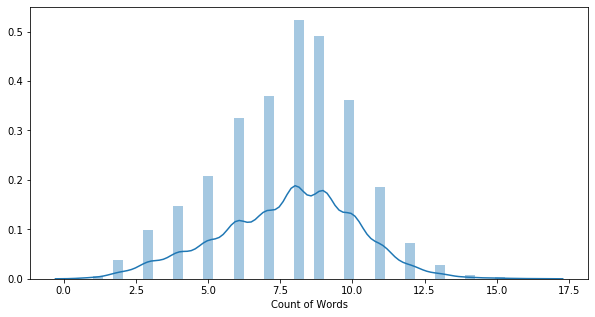

time: 359 ms


In [11]:
wordsCount = train.head(5000)['title'].apply(lambda li: len(li.split()))

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(wordsCount)
plt.xlabel('Count of Words')

### Function Remove StopWords and Ponctuation

  Well! From that insight, I created that function that handles each word that makes up the title, to avoid duplicate words of the same meaning, and removal of those that are not useful for classification. Some key terms that recur in products from various categories like "free shipping", adjectives and colors, as well as words containing digits, punctuation and Stop Words have been excluded.

  In this process some techniques (Word Stemmer and Lemmatization with the NLTK and Spacy libraries) were used to maintain only the main core of the ad title, but not all techniques showed significant improvement in model performance, so the lines are commented. This decrease in performance was caused by the loss of important information.

In [11]:
#Word Stemmer
#portugueseStemmer = SnowballStemmer("portuguese")
#stemmer = RSLPStemmer()

#Remove Ponctuation and Numbers
removeChar = string.punctuation

notUseful = ['kit', 'frete', 'envio', 'gratis', 'pronta', 'entrega', 'nova', 
             'usado', 'usada','novo', 'original', 'cm', 'mm', 'promocao', 
             'combo', 'kg', 'nuevo', 'cm', 'mini', 'oferta', 'litros', 'negro',
             'set', 'par', 'promocao', 'pack', 'kg', 'completo', 'profissional',
             'black', 'grande', 'nuevo', 'nueva', 'tipo', 'ml', 'metros', 
             'universal', 'bivolt', 'new', 'pcs', 'completa', 'red', 'ano', 
             'ii', 'branco', 'branca', 'preto', 'preta', 'azul', 'vermelho', 'cinza', 
             'vermelha', 'rosa', 'verde', 'amarelo', 'unidades', 'digital', 'color',
             'modelo', 'portatil', 'top', 'marca', 'alta', 'lote', ]

stopWordsData = stopwords.words('spanish') + stopwords.words('portuguese') + list(string.ascii_lowercase) + notUseful


def removeStopLine(line):
    #Remove accents
    text = unidecode.unidecode(line)
    #Replace ",./-" for espace
    text = text.translate(str.maketrans(',./-', '    '))
    #Remove ponctuation
    text = text.translate(str.maketrans('', '', removeChar))
    listWords = text.split()
    #listWords = nlp(text)

    #Remove StopWords and Numbers
    #text = [portugueseStemmer.stem(word) for word in listWords if (word not in stopWordsData and not(word.isdigit()))]
    #text = [word.lemma_ for word in listWords if (word.lemma_ not in stopWordsData and not(re.search('\d+', word.lemma_)))]
    text = [word for word in listWords if (word not in stopWordsData and not(re.search('\d+', word)))]
    text = ' '.join(text)
    return text

time: 18.6 ms


After removal StopWords, I checked if title column has been empty to insert a data to fill registry.

In [12]:
#Drop row if length title is zero
def indexesZeroTrain(data):
    indexes = data[data['title_nopunc'].apply(len) == 0].index
    print(len(indexes))
    data.drop(indexes, inplace=True)
    #print(data['title'][indexes])
    #data['title_nopunc'][indexes] = 'nothing'
    return data

#Set to 'nothing' title if length is zero
def indexesZeroTest(data):
    indexes = data[data['title_nopunc'].apply(len) == 0].index
    print(len(indexes))
    data['title'][indexes] = 'nothing'
    data['title_nopunc'][indexes] = 'nothing'
    return data

time: 7.29 ms


### Resize Dataset by defined size

   - Because the training set is so large, I create a new DataFrame using Sklearn train_test_split with the Stratify parameter to maintain the proportion of categories in the training data.

In [0]:
newSize = 500000 / train.shape[0]
_, X_train = train_test_split(train, test_size=newSize, random_state=101, stratify=train.category)

time: 1min 9s


### Train - Remove StopWords

Here, I just apply function for remove StopWords

In [0]:
X_train['title_nopunc'] = X_train['title'].apply(removeStopLine)

X_train = indexesZeroTrain(X_train)

238
time: 36.1 s


In [0]:
X_train.head()

,title,label_quality,language,category,title_nopunc
12377057,"funko ricochete, hanna barbera, na embalagem",reliable,portuguese,ACTION_FIGURES,funko ricochete hanna barbera embalagem
8227516,"kit telecomunicação,aero 500 24v+ regulador +2...",unreliable,portuguese,SOLAR_PANELS,telecomunicacao aero regulador placa solar
4015565,posicionador cinto segurança rosa prisma 2014,unreliable,portuguese,SEAT_BELTS,posicionador cinto seguranca prisma
3801007,stereo sony xplod cdx-g1200u,unreliable,spanish,CAR_STEREOS,stereo sony xplod cdx
17591695,mesa de centro na cor rosa,unreliable,portuguese,COFFEE_TABLES,mesa centro cor


time: 1.06 s


### Category Feature Scaling

The target column data are objects. Then using the Keras to_categorical library, I create a dictionary of the categories and convert it to a binary matrix, which will be used by the classifier.

In [0]:
target_names = X_train['category'].unique()
target_dict = {n:i for i, n in enumerate(target_names)}

y_train = pd.get_dummies(X_train['category'].map(target_dict))

print("Target dataset have a size: {} ".format(y_train.shape,))

Target dataset have a size: (500000, 1588) 
time: 399 ms


### Test - Remove StopWords

It-s the same process applied to StopWords removal training data. Also removes the id column to help in concatenating dataframes.

In [0]:
test["title_nopunc"] = test['title'].apply(removeStopLine)

test = indexesZeroTest(test)

test.drop('id', axis=1, inplace=True)

29
time: 15.3 s


In [0]:
test.head()

,title,language,title_nopunc
0,kit maternidade bolsa-mala baby/bebe vinho men...,portuguese,maternidade bolsa mala baby bebe vinho menina
1,trocador de fraldas fisher price feminino rosa...,portuguese,trocador fraldas fisher price feminino
2,motor ventoinha - fiat idea / palio 1.8 - a 04...,portuguese,motor ventoinha fiat idea palio
3,amortecedor mola batente d dir new civic 14 - ...,portuguese,amortecedor mola batente dir civic
4,cadeirinha de carro bebê princesa princess 9 a...,portuguese,cadeirinha carro bebe princesa princess kgs


time: 11.9 ms


### Function Plot Learning Curves

Used to verified bias and variance of model, and identified overfitting or underfitting.

In [0]:
def plotLearningCurves(history):
    # list all data in history
    keys = list(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[keys[1]])
    plt.plot(history.history[keys[3]])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
   
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history[keys[0]])
    plt.plot(history.history[keys[2]])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.tight_layout()
    
    plt.show()

time: 8.15 ms


### Vectorizer

#### TfIDF

  - As seguintes funções retornam uma matriz de recursos TF-IDF a partir do Dataframe

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(features):
  print("Creating TF-IDF matrix . . .")
  
  vectorizer = TfidfVectorizer(max_features=features)
  return vectorizer.fit_transform(X_train['title_nopunc'])

time: 5.53 ms


In [0]:
def create_model_1(units, features, categories):
  print("Creating Deep Model . . .")

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=units, input_dim=features, activation='relu'))
  model.add(tf.keras.layers.Dense(categories, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

  return model

time: 4.35 ms


In [0]:
vocabularies = [10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

time: 916 µs


In [0]:
scores = list(vocabularies)
scoresLoss = list(vocabularies)
for i, v in enumerate(vocabularies):
  XX_train_Tfidf, XX_test_Tfidf, yy_train_Tfidf, yy_test_Tfidf = train_test_split(get_tfidf(v), y_train, test_size=0.18, random_state=101)

  model_tfidf = create_model_1( 256, XX_train_Tfidf.shape[1], yy_train_Tfidf.shape[1])

  print("Train model with :", v, "/n")
  historyTfidf1 = model_tfidf.fit(XX_train_Tfidf, 
                                  yy_train_Tfidf, 
                                  epochs=3, 
                                  verbose=0,
                                  validation_data=(XX_test_Tfidf, yy_test_Tfidf)
                                )
  scoresLoss[i] ,scores[i] = model_tfidf.evaluate(XX_test_Tfidf, yy_test_Tfidf)

Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 10000
17993/17993 [==============================] - 4s 218us/sample - loss: 1.3667 - acc: 0.7443
Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 15000
17993/17993 [==============================] - 4s 223us/sample - loss: 1.3830 - acc: 0.7412
Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 20000
17993/17993 [==============================] - 4s 219us/sample - loss: 1.3740 - acc: 0.7401
Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 25000
17993/17993 [==============================] - 4s 219us/sample - loss: 1.3671 - acc: 0.7462
Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 30000
17993/17993 [==============================] - 4s 219us/sample - loss: 1.3721 - acc: 0.7437
Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 35000
17993/17993 [==============================] - 4s 234us/samp

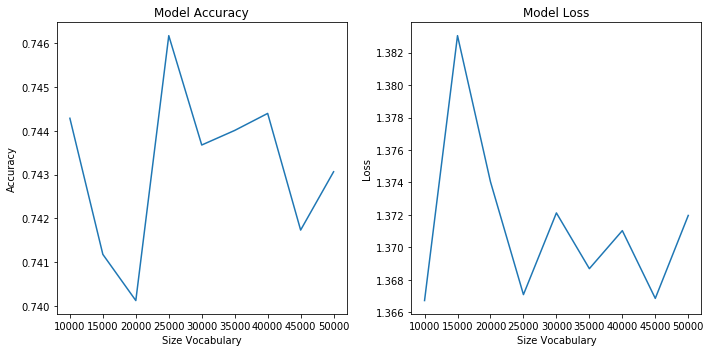

time: 379 ms


In [0]:
#Plot Accuracy
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(vocabularies, scores)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Size Vocabulary')

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(vocabularies, scoresLoss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Size Vocabulary')

plt.tight_layout()

plt.show()

In [0]:
units = [128, 256, 512, 1024, 2048, 4096, 6144, 8192]

time: 1.1 ms


In [0]:
scores = list(units)
scoresLoss = list(units)

XX_train_Tfidf, XX_test_Tfidf, yy_train_Tfidf, yy_test_Tfidf = train_test_split(get_tfidf(25000), y_train, test_size=0.18, random_state=101)

for i, unit in enumerate(units):
  

  model_tfidf = create_model_1( unit, XX_train_Tfidf.shape[1], yy_train_Tfidf.shape[1])

  print("Train model with :", unit, "units")
  history_tfidf_1 = model_tfidf.fit(XX_train_Tfidf, 
                                  yy_train_Tfidf, 
                                  epochs=3, 
                                  verbose=0,
                                  validation_data=(XX_test_Tfidf, yy_test_Tfidf)
                                )
  
  scoresLoss[i] ,scores[i] = model_tfidf.evaluate(XX_test_Tfidf, yy_test_Tfidf)

Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train model with : 128 units /n
17993/17993 [==============================] - 3s 182us/sample - loss: 1.5621 - acc: 0.7275
Creating Deep Model . . .
Train model with : 256 units /n
17993/17993 [==============================] - 4s 199us/sample - loss: 1.3699 - acc: 0.7446
Creating Deep Model . . .
Train model with : 512 units /n
17993/17993 [==============================] - 4s 210us/sample - loss: 1.3334 - acc: 0.7427
Creating Deep Model . . .
Train model with : 1024 units /n
17993/17993 [==============================] - 4s 213us/sample - loss: 1.3550 - acc: 0.7389
Creating Deep Model . . .
Train model with : 2048 units /n
17993/17993 [==============================] - 4s 217us/sample - loss: 1.4238 - acc: 0.7345
Creating Deep Model . . .
Train model with : 4096 units /n
17993/17993 [==============================] - 4s 242us/sample - loss: 1.4638 - acc: 0.7360
Creating Deep Model . . .
Train model with : 6144 units /n
17993/179

Text(0.5, 0, 'Units')

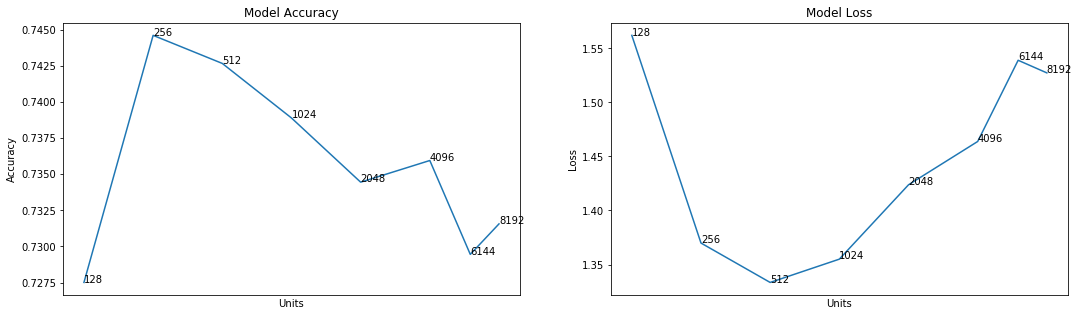

time: 322 ms


In [0]:
import matplotlib.ticker as ticker

#Plot Accuracy
plt.figure(figsize=(18,5))

graf = plt.subplot(1, 2, 1)
graf.plot(units, scores)

for xy in zip(units, scores):
    graf.annotate('%s' % xy[0], xy=xy, textcoords='data')

graf.set_xscale('log')
graf.minorticks_off()
graf.xaxis.set_major_locator(ticker.NullLocator())

graf.set_title('Model Accuracy')
graf.set_ylabel('Accuracy')
graf.set_xlabel('Units')

#Plot Loss
graf_loss = plt.subplot(1, 2, 2)
graf_loss.plot(units, scoresLoss)

for xy in zip(units, scoresLoss):
    graf_loss.annotate('%s' % xy[0], xy=xy, textcoords='data')

graf_loss.set_xscale('log')
graf_loss.minorticks_off()
graf_loss.xaxis.set_major_locator(ticker.NullLocator())

graf_loss.set_title('Model Loss')
graf_loss.set_ylabel('Loss')
graf_loss.set_xlabel('Units')


8192

time: 2.64 ms


In [0]:
XX_train_Tfidf, XX_test_Tfidf, yy_train_Tfidf, yy_test_Tfidf = train_test_split(get_tfidf(25000), y_train, test_size=0.18, random_state=101)

model_tfidf = create_model_1( 256, XX_train_Tfidf.shape[1], yy_train_Tfidf.shape[1])

historyTfidf1 = model_tfidf.fit(XX_train_Tfidf, 
                                yy_train_Tfidf, 
                                epochs=5, 
                                verbose=1,
                                validation_data=(XX_test_Tfidf, yy_test_Tfidf)
                              )

Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train on 81963 samples, validate on 17993 samples
Epoch 1/5
81963/81963 [==============================] - 26s 315us/sample - loss: 4.9275 - acc: 0.3319 - val_loss: 2.4742 - val_acc: 0.6204
Epoch 2/5
81963/81963 [==============================] - 26s 318us/sample - loss: 1.4291 - acc: 0.7629 - val_loss: 1.5686 - val_acc: 0.7204
Epoch 3/5
81963/81963 [==============================] - 26s 315us/sample - loss: 0.6111 - acc: 0.8852 - val_loss: 1.3755 - val_acc: 0.7462
Epoch 4/5
81963/81963 [==============================] - 26s 312us/sample - loss: 0.2713 - acc: 0.9469 - val_loss: 1.3468 - val_acc: 0.7425
Epoch 5/5
81963/81963 [==============================] - 26s 313us/sample - loss: 0.1267 - acc: 0.9738 - val_loss: 1.3533 - val_acc: 0.7425
time: 2min 10s


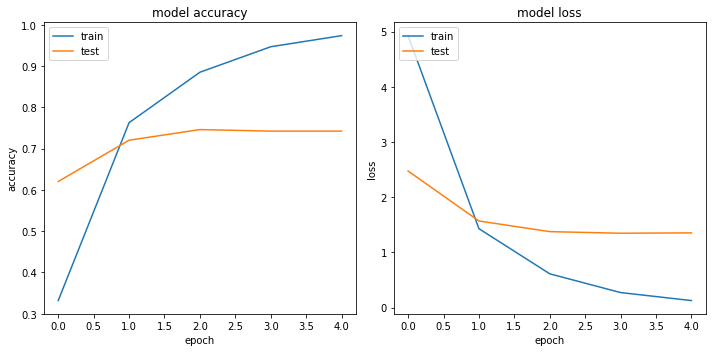

time: 434 ms


In [0]:
plotLearningCurves(historyTfidf1)

In [0]:
XX_train_Tfidf, XX_test_Tfidf, yy_train_Tfidf, yy_test_Tfidf = train_test_split(get_tfidf(25000), y_train, test_size=0.18, random_state=101)

model_tfidf = create_model_1( 256, XX_train_Tfidf.shape[1], yy_train_Tfidf.shape[1])

history_Tfidf_2 = model_tfidf.fit(XX_train_Tfidf, 
                                yy_train_Tfidf, 
                                epochs=5, 
                                verbose=1,
                                batch_size=32,
                                validation_data=(XX_test_Tfidf, yy_test_Tfidf)
                              )

Creating TF-IDF matrix . . .
Creating Deep Model . . .
Train on 81963 samples, validate on 17993 samples
Epoch 1/5
81963/81963 [==============================] - 25s 311us/sample - loss: 4.8902 - acc: 0.3439 - val_loss: 2.4636 - val_acc: 0.6226
Epoch 2/5
81963/81963 [==============================] - 25s 308us/sample - loss: 1.4121 - acc: 0.7630 - val_loss: 1.5664 - val_acc: 0.7221
Epoch 3/5
81963/81963 [==============================] - 25s 306us/sample - loss: 0.5976 - acc: 0.8893 - val_loss: 1.3723 - val_acc: 0.7428
Epoch 4/5
81963/81963 [==============================] - 26s 314us/sample - loss: 0.2678 - acc: 0.9475 - val_loss: 1.3475 - val_acc: 0.7437
Epoch 5/5
81963/81963 [==============================] - 27s 332us/sample - loss: 0.1251 - acc: 0.9747 - val_loss: 1.3618 - val_acc: 0.7442
time: 2min 9s


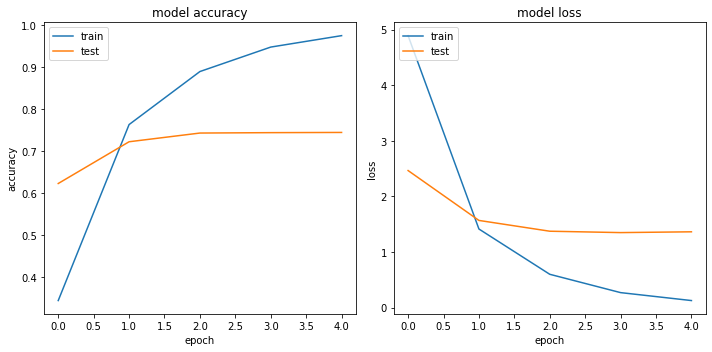

time: 400 ms


In [0]:
plotLearningCurves(history_Tfidf_2)

Model 

In [0]:
XX_train_Tfidf, XX_test_Tfidf, yy_train_Tfidf, yy_test_Tfidf = train_test_split(get_tfidf(25000), y_train, test_size=0.18, random_state=101)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(XX_train_Tfidf.shape[1], )))
model.add(tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history_Tfidf_cat = model.fit(XX_train_Tfidf, 
                         yy_train_Tfidf, 
                         epochs=3, 
                         verbose=1,
                         validation_data=(XX_test_Tfidf, yy_test_Tfidf)
                         )

Creating TF-IDF matrix . . .
Train on 81963 samples, validate on 17993 samples
Epoch 1/3
81963/81963 [==============================] - 17s 205us/sample - loss: 4.8552 - categorical_accuracy: 0.3437 - val_loss: 2.3969 - val_categorical_accuracy: 0.6314
Epoch 2/3
81963/81963 [==============================] - 16s 201us/sample - loss: 1.4328 - categorical_accuracy: 0.7550 - val_loss: 1.5375 - val_categorical_accuracy: 0.7244
Epoch 3/3
81963/81963 [==============================] - 16s 201us/sample - loss: 0.6788 - categorical_accuracy: 0.8674 - val_loss: 1.3577 - val_categorical_accuracy: 0.7408
time: 50.8 s


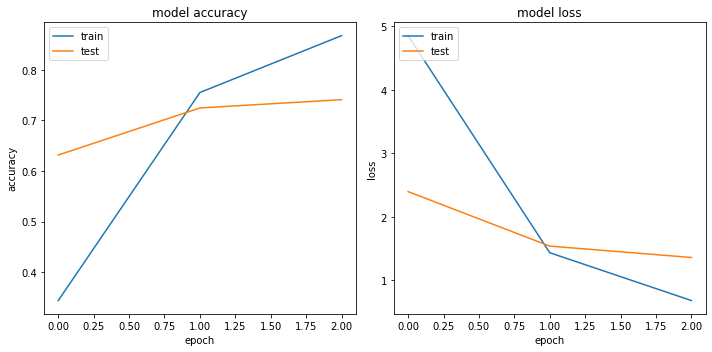

time: 396 ms


In [0]:
plotLearningCurves(history_Tfidf_cat)

OK! 

After these tests we can set same hyperparameters:
  - Size of vocabulary of 25000
  - One Dense layer with 256 units
  - Three epochs is enought

Now ...

#### KBest

...

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train.title_nopunc.astype(str))
X_train_count.shape

kbest = SelectKBest(score_func = chi2, k = 25000)
kbest.fit(X_train_count, y_train)

SelectKBest(k=25000, score_func=<function chi2 at 0x7ff1dc95e8c8>)

time: 22.2 s


In [0]:
X_train_KBest = kbest.transform(X_train_count)
print(X_train_KBest.shape)

(99956, 25000)
time: 13.7 ms


In [0]:
XX_train_KBest, XX_test_KBest, yy_train_KBest, yy_test_KBest = train_test_split(X_train_KBest, y_train, test_size=0.18, random_state=101)

time: 154 ms


In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(X_train_KBest.shape[1], )))
model.add(tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['acc'])

historyKBest = model.fit(XX_train_KBest, 
                         yy_train_KBest, 
                         epochs=3, 
                         verbose=1,
                         validation_data=(XX_test_KBest, yy_test_KBest)
                         )

Train on 81963 samples, validate on 17993 samples
Epoch 1/3
81963/81963 [==============================] - 18s 216us/sample - loss: 3.9038 - acc: 0.4536 - val_loss: 1.8658 - val_acc: 0.6858
Epoch 2/3
81963/81963 [==============================] - 18s 218us/sample - loss: 1.0852 - acc: 0.7943 - val_loss: 1.4245 - val_acc: 0.7354
Epoch 3/3
81963/81963 [==============================] - 18s 222us/sample - loss: 0.5042 - acc: 0.8940 - val_loss: 1.3711 - val_acc: 0.7423
time: 54.1 s


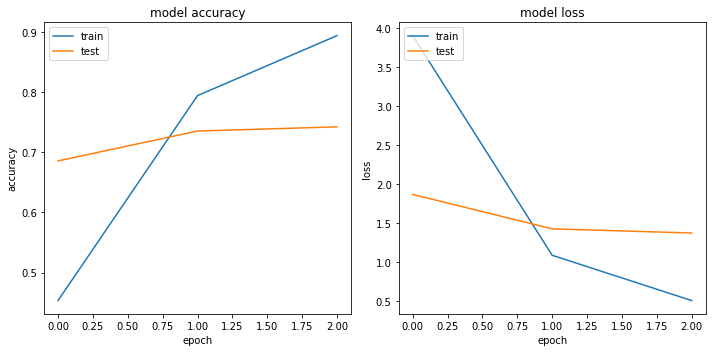

time: 395 ms


In [0]:
plotLearningCurves(historyKBest)

#### TF-IDF N-Gram

In [0]:
vectorizer_nGram = TfidfVectorizer(ngram_range=(1,2), analyzer='word', max_features=25000) # You can still specify n-grams here.
X_train_nGram = vectorizer_nGram.fit_transform(X_train['title_nopunc'].tolist())

time: 2.14 s


In [0]:
XX_train_nGram, XX_test_nGram, yy_train_nGram, yy_test_nGram = train_test_split(X_train_nGram, y_train, test_size=0.18, random_state=101)

time: 175 ms


In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(XX_train_nGram.shape[1], )))
model.add(tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['acc'])

historynGram = model.fit(XX_train_nGram, 
                         yy_train_nGram, 
                         epochs=3, 
                         verbose=1,
                         validation_data=(XX_test_nGram, yy_test_nGram)
                         )

Train on 81963 samples, validate on 17993 samples
Epoch 1/3
81963/81963 [==============================] - 17s 207us/sample - loss: 4.7517 - acc: 0.3687 - val_loss: 2.3204 - val_acc: 0.6454
Epoch 2/3
81963/81963 [==============================] - 17s 202us/sample - loss: 1.4146 - acc: 0.7574 - val_loss: 1.5471 - val_acc: 0.7224
Epoch 3/3
81963/81963 [==============================] - 17s 213us/sample - loss: 0.7114 - acc: 0.8589 - val_loss: 1.4162 - val_acc: 0.7345
time: 51.4 s


In [0]:
frequencies = sum(X_train_nGram).toarray()[0]
x = pd.DataFrame(frequencies, index=vectorizer_nGram.get_feature_names(), columns=['frequency'])
x.sort_values(by=['frequency'], ascending=False, inplace=True)


time: 1min 52s


### Word Embeeding

  - A sequência a seguir concatena os dataframes de treino e test a fim de que o algoritmo de treinamento esteva familiarizado com o conteúdo do dataset de test. 
  - Define o tamanho do vocabulário com as palavras mais importantes, classificadas pelo Keras Tokenizer
  - Verifica se alguma linha ficou vazia e adiciona o title tratado para não perder aquele registro.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Activation, LSTM

time: 1.55 ms


In [0]:
max_features = 25000
maxlen = 10

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train['title_nopunc'])

X_train_Emb = tokenizer.texts_to_sequences(X_train['title_nopunc'])

print('Loading data...')
print(len(X_train_Emb), 'train sequences')

X_train_Emb = pad_sequences(X_train_Emb, maxlen=maxlen)
print('X_train shape:', X_train_Emb.shape)

Loading data...
99956 train sequences
X_train shape: (99956, 10)
time: 2.74 s


In [0]:
XX_train_Emb, XX_test_Emb, yy_train_Emb, yy_test_Emb = train_test_split(X_train_Emb, y_train, test_size=0.18, random_state=101)

time: 159 ms


#### Model Just Embedding

100k Accuracy: 0.9947 Val_accuracy: 0.7161

819629/819629 [==============================] - 1562s 2ms/sample - loss: 0.7554 - accuracy: 0.8371 - val_loss: 0.9443 - val_accuracy: 0.8152

In [0]:
print('Build model...')

category_size = y_train.shape[1]

model = Sequential()
model.add(Embedding(max_features, 256))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(category_size, activation='softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print('Train...')
historyEmb2 = model.fit(XX_train_Emb, 
                        yy_train_Emb,
                        batch_size=32,
                        epochs=3,
                        validation_data=(XX_test_Emb, yy_test_Emb)
                        )

#Model Evaluate
score, acc = model.evaluate(XX_test_Emb, yy_test_Emb, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Train on 81963 samples, validate on 17993 samples
Epoch 1/3
81963/81963 [==============================] - 123s 1ms/sample - loss: 5.1365 - accuracy: 0.1882 - val_loss: 2.7891 - val_accuracy: 0.5219
Epoch 2/3
81963/81963 [==============================] - 121s 1ms/sample - loss: 1.9784 - accuracy: 0.6355 - val_loss: 1.8711 - val_accuracy: 0.6737
Epoch 3/3
17993/17993 [==============================] - 3s 170us/sample - loss: 1.7388 - accuracy: 0.6990
Test score: 1.738840732620575
Test accuracy: 0.69904965
time: 6min 13s


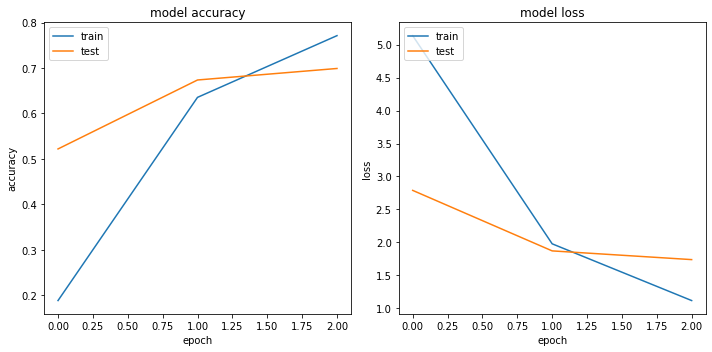

time: 414 ms


In [0]:
plotLearningCurves(historyEmb2)

#### Model with Convolution Neural Network

In [0]:
embedding_size = 32

# Convolution
kernel_size = 3
filters = 64

print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D())
model.add(LSTM(1024))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print('Train...')
historyEmb = model.fit(XX_train_Emb, 
                       yy_train_Emb,
                       batch_size=32,
                       epochs=6,
                       validation_data=(XX_test_Emb, yy_test_Emb)
                       )

#Model Evaluate
score, acc = model.evaluate(XX_test_Emb, yy_test_Emb, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 81963 samples, validate on 17993 samples
Epoch 1/6
81963/81963 [==============================] - 18s 225us/sample - loss: 6.0652 - acc: 0.0509 - val_loss: 4.3768 - val_acc: 0.2192
Epoch 2/6
81963/81963 [==============================] - 18s 220us/sample - loss: 3.4531 - acc: 0.3451 - val_loss: 2.8001 - val_acc: 0.4964
Epoch 3/6
81963/81963 [==============================] - 18s 221us/sample - loss: 2.2351 - acc: 0.5448 - val_loss: 2.3857 - val_acc: 0.5674
Epoch 4/6
81963/81963 [==============================] - 18s 221us/sample - loss: 1.6432 - acc: 0.6413 - val_loss: 2.2260 - val_acc: 0.6164
Epoch 5/6
81963/81963 [==============================] - 18s 219us/sample - loss: 1.2682 - acc: 0.7084 - val_loss: 2.1911 - val_acc: 0.6267
Epoch 6/6
17993/17993 [==============================] - 2s 89us/sample - loss: 2.2155 - acc: 0.6386
Test score: 2.215527768331975
Test accuracy: 0.6385817
time: 1min 52s


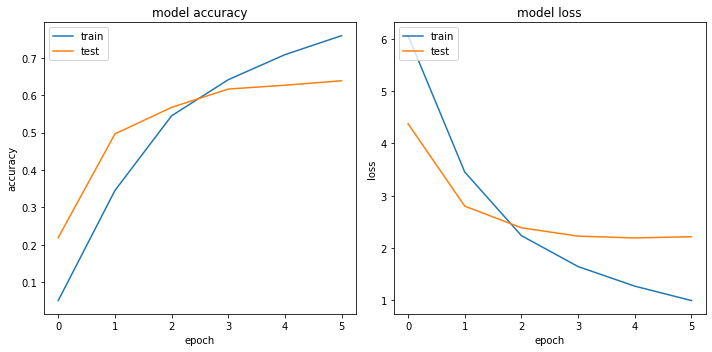

time: 371 ms


In [0]:
plotLearningCurves(historyEmb)

time: 12.5 ms


### KFold Method


In this approach, I split dataset in folds and I training model with all folds adding the predict to a DataFrame of results.

The procedure, for the training part, may be described as follows:


1. Split the total training set into folds(here **train** and .**val (validation)** )

2. Iterate in all Folds and train the model (**train**)

3. Predict results this Fold on the second part (**val**)

4. With the predictions from 3 I add to DataFrame results.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  I train deep model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions.

For the prediction part , in DataFrame with results I apply np.argmax to extract the maximum column value and convert on category results.

The following image explains this approach.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def make_model(x_size, y_size):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(x_size, )))
  model.add(tf.keras.layers.Dense(units=y_size, activation='softmax'))

  model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

  return model

time: 6.15 ms


In [0]:
X = get_tfidf(25000)
folds = list(KFold(n_splits=4, random_state=101, shuffle=False).split(X))
#folds = list(StratifiedKFold(n_splits=4).split(X, y_train))

y_pred = np.zeros((X.shape[0], y_train.shape[1]))

Creating TF-IDF matrix . . .
time: 7.11 s


In [0]:
for i, (train_idx, val_idx) in  enumerate(folds):
    print(f"Fold {i+1}")
    model = make_model(X.shape[1], y_train.shape[1])
    print("Train Model . . .")
    model.fit(X[train_idx],
              y_train[train_idx],
              epochs=3, 
              verbose=0,
              validation_data=(X[val_idx], y_train[val_idx])
              )

    pred_val = model.predict(X[val_idx])
    score = accuracy_score(np.argmax(pred_val, axis=1), np.argmax(y_train[val_idx], axis=1))
    y_pred[val_idx] += pred_val
    
    print(f'Scored {score:.3f} on validation data \n \n')


Fold 1
Train Model . . .
Scored 0.798 on validation data 
 

Fold 2
Train Model . . .
Scored 0.800 on validation data 
 

Fold 3
Train Model . . .
Scored 0.798 on validation data 
 

Fold 4
Train Model . . .
Scored 0.798 on validation data 
 

time: 26min 40s


In [0]:
final_score = accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_train, axis=1))
print(f'Scored final {final_score:.3f} \n')

Scored final 0.799 

time: 1.77 s


## Training Model

After training and refining the model with several hyperparameters I will train the model with the best approach, considering execution time, computational resource and accuracy.

Well, I will do the following steps:

1. Split Train Dataset with a percentage of the total;
2. I remove StopWords and other useless information from the Training and Test Dataset;
3. Mapping target variable with pd.get_dummies;
4. Concatenate train and test to create a vocabulary that contains words from both;
5. I divide data into train and test;
6. Finally, I train the neural model.

In [14]:
print(psutil.virtual_memory())

svmem(total=27395407872, available=23205855232, percent=15.3, used=5157085184, free=13785411584, active=3880927232, inactive=9156321280, buffers=98680832, cached=8354230272, shared=921600, slab=385548288)
time: 1.29 ms


In [15]:
newSize = 2000000 / train.shape[0]
_, X_train = train_test_split(train, test_size=newSize, random_state=101, stratify=train.category)

time: 1min 8s


In [0]:
X_train['title_nopunc'] = X_train['title'].apply(removeStopLine)

X_train = indexesZeroTrain(X_train)

2209
time: 5min 13s


In [0]:
test["title_nopunc"] = test['title'].apply(removeStopLine)

test = indexesZeroTest(test)

In [0]:
test.drop('id', axis=1, inplace=True)

29
time: 15.5 s


In [16]:
target_names = X_train['category'].unique()
target_dict = {n:i for i, n in enumerate(target_names)}

y_train = pd.get_dummies(X_train['category'].map(target_dict))

time: 1.46 s


In [17]:
print(psutil.virtual_memory())

svmem(total=27395407872, available=19989671936, percent=27.0, used=8342962176, free=10598182912, active=7092076544, inactive=9127010304, buffers=98861056, cached=8355401728, shared=921600, slab=385630208)
time: 1.49 ms


In [18]:
size_train = X_train.shape[0]
size_test = test.shape[0]

X_train = X_train.append(test)

time: 592 ms


In [19]:
vectorizer = TfidfVectorizer(max_features=25000)
#X_train = vectorizer.fit_transform(X_train['title_nopunc'])
X_train = vectorizer.fit_transform(X_train['title'])

time: 21.5 s


In [20]:
X_test = X_train[-size_test:]
X_train = X_train[:size_train]

time: 185 ms


In [21]:
XX_train_Tfidf, XX_test_Tfidf, yy_train_Tfidf, yy_test_Tfidf = train_test_split(X_train, y_train, test_size=0.18, random_state=101)

time: 3.3 s


In [22]:
print(psutil.virtual_memory())

svmem(total=27395407872, available=17319006208, percent=36.8, used=13905412096, free=5033357312, active=9751580672, inactive=12020924416, buffers=99090432, cached=8357548032, shared=921600, slab=385683456)
time: 2.07 ms


In [23]:
#alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
#print(alldfs)

time: 3.4 ms


In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(XX_train_Tfidf.shape[1], )))
model.add(tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['acc'])

history_Tfidf_cat = model.fit(XX_train_Tfidf, 
                         yy_train_Tfidf, 
                         epochs=3, 
                         verbose=1,
                         validation_data=(XX_test_Tfidf, yy_test_Tfidf)
                         )

Train on 1640000 samples, validate on 360000 samples
Epoch 1/3
1640000/1640000 [==============================] - 398s 243us/sample - loss: 1.1802 - acc: 0.7787 - val_loss: 0.8376 - val_acc: 0.8254
Epoch 2/3
1640000/1640000 [==============================] - 383s 234us/sample - loss: 0.6698 - acc: 0.8549 - val_loss: 0.8803 - val_acc: 0.8292
Epoch 3/3
1640000/1640000 [==============================] - 388s 237us/sample - loss: 0.5453 - acc: 0.8811 - val_loss: 0.9863 - val_acc: 0.8257
time: 19min 30s


### Making Results

OK! There is little left!

Now it's time to predict some categories.

This is simple:
1. The model predict classes;
2. Mapping this results codes in real categories;
3. Insert the column category with results in **test** Dataset;
4. Create csv file;
5. Download file and submit on challenge portal. 

In [25]:
result = model.predict_classes(X_test)

time: 24.1 s


In [26]:
test['category'] = result

time: 2.35 ms


In [27]:
target_dict_inv = dict(map(reversed, target_dict.items()))
test['category'] = test['category'].map(target_dict_inv)

time: 20 ms


In [28]:
submission = test[['category']]
submission['id'] = submission.index
submission1 = submission[['id','category']]
submission1.head()

,id,category
0,0,DIAPER_BAGS
1,1,BABY_DIAPERS
2,2,ENGINE_COOLING_FAN_MOTORS
3,3,AUTOMOTIVE_SHOCK_ABSORBER_BUMP_STOPS
4,4,BABY_CAR_SEATS


time: 756 ms


In [29]:
submission1.to_csv('submission.csv', index=False)

time: 635 ms


In [30]:
#for dirname, _, filenames in os.walk('/content'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

time: 561 µs


In [31]:
from google.colab import files

os.chdir(r'/content')

files.download('submission.csv')

time: 29.3 s


### Conclusion

What was the result?

    In the challenge portal the model scored an accuracy of:
    0.8318

Anyway, the project was a little extensive, as there are many tests with different algorithms and parameters. What can I conclude:

1. A neural network with many units and layers is not always better than a simple network (start small);
2. The process of removing stopwords (cleaning the data) did not make a big difference in the final result, as the test with the cleaning results in an accuracy of 0.8318 and without cleaning in 0.8303. Work thrown away? No, you need to learn from that.
3. What can still be done? The accuracy is still not spectacular, I need to check where the classification errors are, how I can solve them and still make the model simpler and more accurate.
4. How? Adding more data to the model to try to solve the overffiting problem, try the KFold model if Colab has enough memory and modify the vocabulary as the data increase.

Finally, the business problem can be solved with data science with good accuracy and make the classification, search and recommendation of products much better.

If this notebook was useful or there are any suggestions I would appreciate any feedback.